In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
temp = 15
filename = f"./data/streams_{temp}.csv"

df = pd.read_csv(filename)
df

,Stream Name,Supply,Target,Cp,U
0,Cooled Product-1,363.40,171.32,6.391,0.748591
1,Cooled Product-2,171.32,89.00,32.083,0.748591
2,Cooled Water Stream,165.30,30.00,3.420,2.342950
3,Feed To Column2-1,156.80,154.98,42.071,1.790000
4,Feed To Column2-2,154.98,139.00,6.831,1.790000
5,T-101 Condenser,128.59,126.04,877.923,4.500000
6,T-100 Condenser,48.39,45.90,806.572,4.500000
7,DME Final Product,45.90,30.00,4.523,1.000000
8,Heated Methanol-1,43.07,146.54,15.627,0.806375
9,Heated Methanol-2,146.54,167.23,144.985,0.806375


In [3]:
def is_hot_cold(row):
    if row["Supply"] > row["Target"]:
        return "Hot"
    else:
        return "Cold"
def get_enthalpy(row):
    return (row["Target"] - row["Supply"]) *row["Cp"]

In [4]:
df["Stream Type"] = df.apply(is_hot_cold,axis=1)
df["Delta H"] = df.apply(get_enthalpy,axis=1)
df["Abs Delta H"] = df["Delta H"].apply(abs)
assert abs(df["Delta H"].sum()) < 1, "Process is unbalanced, check that net enthalpy is close to 0"
df

,Stream Name,Supply,Target,Cp,U,Stream Type,Delta H,Abs Delta H
0,Cooled Product-1,363.40,171.32,6.391,0.748591,Hot,-1227.58328,1227.58328
1,Cooled Product-2,171.32,89.00,32.083,0.748591,Hot,-2641.07256,2641.07256
2,Cooled Water Stream,165.30,30.00,3.420,2.342950,Hot,-462.72600,462.72600
3,Feed To Column2-1,156.80,154.98,42.071,1.790000,Hot,-76.56922,76.56922
4,Feed To Column2-2,154.98,139.00,6.831,1.790000,Hot,-109.15938,109.15938
5,T-101 Condenser,128.59,126.04,877.923,4.500000,Hot,-2238.70365,2238.70365
6,T-100 Condenser,48.39,45.90,806.572,4.500000,Hot,-2008.36428,2008.36428
7,DME Final Product,45.90,30.00,4.523,1.000000,Hot,-71.91570,71.91570
8,Heated Methanol-1,43.07,146.54,15.627,0.806375,Cold,1616.92569,1616.92569
9,Heated Methanol-2,146.54,167.23,144.985,0.806375,Cold,2999.73965,2999.73965


In [5]:
cold_df = df[df["Stream Type"] == "Cold"].copy()
hot_df = df[df["Stream Type"] == "Hot"].copy()


cold_df["Low"],cold_df["High"] = cold_df["Supply"],cold_df["Target"]
hot_df["Low"],hot_df["High"] = hot_df["Target"],hot_df["Supply"]

cold_df = cold_df.sort_values(by=["Low","High"])
hot_df = hot_df.sort_values(by=["Low","High"])



In [6]:
def inbetween(row,value):
    low = row["Low"]
    high = row["High"]
    c_p = row["Cp"]
    if value >= low and value < high:
        return c_p
    else:
        return 0

def inbetween_U(row,value):
    low = row["Low"]
    high = row["High"]
    u = row["U"]
    if value >= low and value < high:
        return u
    else:
        return 0

def get_regions(df):
    streams = df[["Low","High","Cp","U"]].copy()
    partitions = df["Low"].tolist()
    partitions.extend(df["High"].tolist())

    partitions = sorted(list(set(partitions)))
    regions = []
    for i,pt in enumerate(partitions[:-1]):
    
        cps = streams.apply(inbetween, value=pt,axis=1).tolist()
        cps = [i for i in cps if i > 0]
        tot_cp = sum(cps)

        u_s = streams.apply(inbetween_U, value=pt,axis=1).tolist()
        u_s = [i for i in u_s if i > 0]

        heat_load = tot_cp*(partitions[i+1]- pt)
        info = {
            "cold":pt,"hot":partitions[i+1],"cps":cps,"total_cp":tot_cp,
            "heat_load": heat_load, "U_s": u_s
        }
        
        regions.append(info)

    region_df = pd.DataFrame(regions)
    region_df["heat_load_sum"] = region_df["heat_load"].expanding(1).sum()
    return region_df

In [7]:
hot_reg = get_regions(hot_df)
cold_reg = get_regions(cold_df)

In [8]:
def final_regions(hot_reg, cold_reg):
    all_loads = hot_reg["heat_load_sum"].tolist() + cold_reg["heat_load_sum"].tolist()
    
    all_loads.sort()
    cold_temp = cold_reg.iloc[0,0]
    hot_temp = hot_reg.iloc[0,0]
    current_load = 0
    entries = []
    for target_load in all_loads[:-1]:
        heat_load_region = target_load - current_load
        if target_load in hot_reg["heat_load_sum"].tolist():
            hot_in = hot_temp  
            # If statement for duplicate loads (regions where there are no cold/hot streams)
            if current_load == target_load:
                hot_out = hot_reg[hot_reg["heat_load_sum"] == target_load]["hot"].iloc[-1]
                hot_cp = hot_reg[hot_reg["heat_load_sum"] == target_load]["total_cp"].iloc[-1]
                hot_cps = hot_reg[hot_reg["heat_load_sum"] == target_load]["cps"].iloc[-1]
                hot_u_s = hot_reg[hot_reg["heat_load_sum"] == target_load]["U_s"].iloc[-1]
            else:
                
                hot_out = hot_reg[hot_reg["heat_load_sum"] == target_load]["hot"].iloc[0]
                hot_cp = hot_reg[hot_reg["heat_load_sum"] == target_load]["total_cp"].iloc[0]
                hot_cps = hot_reg[hot_reg["heat_load_sum"] == target_load]["cps"].iloc[0]
                hot_u_s = hot_reg[hot_reg["heat_load_sum"] == target_load]["U_s"].iloc[0]
            # Find Correct Row
            cold_in = cold_temp
            row = find_row(cold_reg, target_load)
            # print("Find Cold",row)
            cold_cp = cold_reg.iloc[row,3]
            cold_cps = cold_reg.iloc[row,2]
            cold_out = heat_load_region/cold_cp + cold_in
            cold_u_s = cold_reg.iloc[row,5]

        elif target_load in cold_reg["heat_load_sum"].tolist():
            cold_in = cold_temp 

            # If statement for duplicate loads (regions where there are no cold/hot streams)
            if current_load == target_load:
                cold_out = cold_reg[cold_reg["heat_load_sum"] == target_load]["hot"].iloc[-1]
                cold_cp = cold_reg[cold_reg["heat_load_sum"] == target_load]["total_cp"].iloc[-1]
                cold_cps = cold_reg[cold_reg["heat_load_sum"] == target_load]["cps"].iloc[-1]
                cold_u_s = cold_reg[cold_reg["heat_load_sum"] == target_load]["U_s"].iloc[-1]
            else:
                cold_out = cold_reg[cold_reg["heat_load_sum"] == target_load]["hot"].iloc[0]
                cold_cp = cold_reg[cold_reg["heat_load_sum"] == target_load]["total_cp"].iloc[0]
                cold_cps = cold_reg[cold_reg["heat_load_sum"] == target_load]["cps"].iloc[0]
                cold_u_s = cold_reg[cold_reg["heat_load_sum"] == target_load]["U_s"].iloc[0]
            
            hot_in = hot_temp
            row = find_row(hot_reg, target_load)
            # print("Find Hot", row,target_load)
            hot_cp = hot_reg.iloc[row,3]
            hot_cps = hot_reg.iloc[row,2]
            hot_u_s = hot_reg.iloc[row,5]
            hot_out = heat_load_region/hot_cp + hot_in

        hot_temp = hot_out
        cold_temp = cold_out
        current_load = target_load
        new_entry={
            "cold_in":cold_in,"cold_out":cold_out,"cold_cps":cold_cps,"cold_u_s":cold_u_s,"cold_cp":cold_cp,
            "hot_in":hot_in,"hot_out":hot_out,"hot_cps": hot_cps,"hot_u_s": hot_u_s, "hot_cp":hot_cp, 
            "heat_load":target_load, "heat_load_region": heat_load_region
        }
        entries.append(new_entry)
    return pd.DataFrame(entries)
    

def find_row(df, load):
    ls = [0] + df["heat_load_sum"].tolist()
    for i, val in enumerate(ls[:-1]):
        if load > val and load <= ls[i+1]:
            return i
    return len(ls) -1

In [9]:
final = final_regions(hot_reg, cold_reg)
final

,cold_in,cold_out,cold_cps,cold_u_s,cold_cp,hot_in,hot_out,hot_cps,hot_u_s,hot_cp,heat_load,heat_load_region
0,5.000000,6.132679,[111.5],[2.5],111.500,30.000000,45.900000,"[4.523, 3.42]","[1.0, 2.34295]",7.943,126.29370,126.29370
1,6.132679,15.000000,[111.5],[2.5],111.500,45.900000,47.120637,"[3.42, 806.572]","[2.34295, 4.5]",809.992,1115.00000,988.70630
2,15.000000,30.000000,[],[],0.000,47.120637,47.120637,"[3.42, 806.572]","[2.34295, 4.5]",809.992,1115.00000,0.00000
3,30.000000,33.389621,[303.33],[2.5],303.330,47.120637,48.390000,"[3.42, 806.572]","[2.34295, 4.5]",809.992,2143.17378,1028.17378
4,33.389621,33.847493,[303.33],[2.5],303.330,48.390000,89.000000,[3.42],[2.34295],3.420,2282.05998,138.88620
5,33.847493,38.182808,[303.33],[2.5],303.330,89.000000,126.040000,"[3.42, 32.083]","[2.34295, 0.748590663]",35.503,3597.09110,1315.03112
6,38.182808,43.070000,[303.33],[2.5],303.330,126.040000,127.662936,"[3.42, 32.083, 877.923]","[2.34295, 0.748590663, 4.5]",913.426,5079.52310,1482.43200
7,43.070000,45.000000,"[303.33, 15.627]","[2.5, 0.806375]",318.957,127.662936,128.336868,"[3.42, 32.083, 877.923]","[2.34295, 0.748590663, 4.5]",913.426,5695.11011,615.58701
8,45.000000,59.796013,[15.627],[0.806375],15.627,128.336868,128.590000,"[3.42, 32.083, 877.923]","[2.34295, 0.748590663, 4.5]",913.426,5926.32740,231.21729
9,59.796013,83.446504,[15.627],[0.806375],15.627,128.590000,139.000000,"[3.42, 32.083]","[2.34295, 0.748590663]",35.503,6295.91363,369.58623


In [10]:
def log_mean(row):
    """
    Pandas Apply function to calculate log mean temp

    Note: This formula might be a bit confusing because out in this case is 
    defined to be the higher temperature (cold_out here is actually cold in )
    
    Difference in notation is for easier code when sorting from smallest to largest
    """
    t1 = row["hot_out"] - row["cold_out"]
    t2 = row["hot_in"] - row["cold_in"]
    return (t1-t2)/math.log(t1/t2)

def cold_q_s(row):
    cold_cp_total = row["cold_cp"]
    normalised_cp = [i/cold_cp_total for i in row["cold_cps"]]
    q_s = [i*row["heat_load_region"] for i in normalised_cp]

    return q_s

def hot_q_s(row):
    hot_cp_total = row["hot_cp"]
    normalised_cp = [i/hot_cp_total for i in row["hot_cps"]]
    q_s = [i*row["heat_load_region"] for i in normalised_cp]

    return q_s

def get_area(row):
    if row["heat_load_region"] == 0:
        return 0 
    cold_qs = row["cold_qs"]
    cold_u_s = row["cold_u_s"]
    assert len(cold_qs) == len(cold_u_s), "Should have the same number of q and u"
    cold_q_u = [q/u for q,u in zip(cold_qs, cold_u_s)]

    hot_qs = row["hot_qs"]
    hot_u_s = row["hot_u_s"]
    hot_q_u = [q/u for q,u in zip(hot_qs, hot_u_s)]

    q_u_sum = sum(cold_q_u) + sum(hot_q_u)

    assert len(hot_qs) == len(hot_u_s), "Should have the same number of q and u"    

    return q_u_sum/row["log_mean"]   

def area_targeting(final_df):
    """
    Perform the calculations once the regions are segmented 
    """
    final_df["log_mean"] = final_df.apply(log_mean,axis = 1)
    final_df["cold_qs"] = final_df.apply(cold_q_s,axis=1)
    final_df["hot_qs"] = final_df.apply(hot_q_s,axis=1)
    final_df["area"] = final_df.apply(get_area,axis=1)
    return final_df.copy()
    
 

In [11]:
area_target = area_targeting(final)
print(area_target["area"].sum())

595.9130769270968


In [12]:
def plot_bcc(final_df):
    # getting cold points
    fig,ax = plt.subplots(figsize = (12,8))
    cold_points = [[final_df.iloc[0,0],0]]
    cold_points = cold_points + final_df[["cold_out","heat_load"]].values.tolist() 
    cold_points = np.array(cold_points)
    
    plt.plot(cold_points[:,1],cold_points[:,0],c="blue")

    hot_points = [[final_df.iloc[0,5],0]]
    hot_points = hot_points + final_df[["hot_out","heat_load"]].values.tolist() 
    hot_points = np.array(hot_points)
    plt.plot(hot_points[:,1],hot_points[:,0],c="red")
    
    plt.vlines(hot_points[:,1],ymin = final_df.iloc[0,0], ymax= final_df.iloc[-1,6],linestyles="--")

    plt.xlabel("ΔH / kW")
    plt.ylabel("Temperature/°C")
    plt.title(f"Balanced Composite Curve - ΔT={temp}°C")
    plt.savefig("bcc/"+ filename[:-4]+".png")

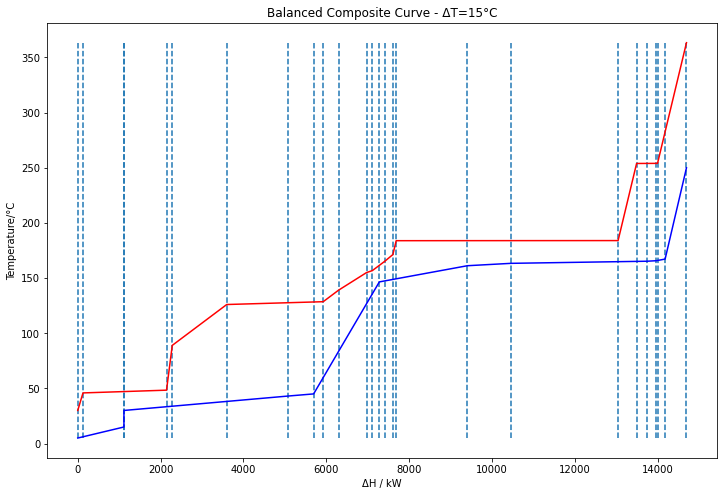

In [13]:
plot_bcc(final)